## Klasifikace zápalu plic z rentgenových snímků pomocí jednoduché konvoluční neuronové sítě

Jako první praktický příklad si ukážeme binární klasifikaci rentgenových snímků do dvou tříd pomocí jednoduché CNN.
Pro tuto a všechny další deep learning příklady bude využíván framework Keras s TensorFlow backendem.
Cílem tohoto příkladu je demonstrovat využití konvolučních neuronových sítí v lékařské diagnostice. Konkrétně se
nyní budeme zabývat naučením jednoduchého CNN klasifikátoru, který dokáže klasifikovat rentgenové snímky hrudníku pacienta do dvou tříd (má\nemá zápal plic), jedná se tedy o úlohu binární klasifikace.
### Datová množina
Datová množina je organizována do tří adresářů (train, test, val), každý adresář obsahuje dva podadresáře pro každou kategorii snímků (PNEUMONIA/NORMAL). K dispozici je celkem 5 863 rentgenových snímků ve formátu JPEG.

Rentgenové snímky hrudníku jsou od dětských pacientů ve věku od jednoho do pěti let pořízené z Guangzhou Women and Children’s Medical Center. Veškeré rentgenové snímky hrudníku byly pořízeny jako součást rutinní klinické péče o pacienty.

Datová množina je obsažena v příloze bakalářské práce v adresáři chest_xray a zároveň je volně dostupný na webu Kaggle:
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
import keras.optimizers
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import keras.backend as K
import tensorflow as tf

Než začneme, nejprve se podíváme na rozložení snímků v adresářích

In [2]:
path = 'C:\\Users\\pajak\\Desktop\\Bakalářská práce\\příklady\\chest_xray\\'

print('Number of normal training images -> ', len(os.listdir(path + 'train\\NORMAL')))
print('Number of pneumonia training images -> ', len(os.listdir(path + 'train\\PNEUMONIA')))
print('Number of normal validation images -> ', len(os.listdir(path + 'val\\NORMAL')))
print('Number of pneumonia validation images -> ', len(os.listdir(path + 'val\\PNEUMONIA')))
print('Number of normal testing images -> ', len(os.listdir(path + 'test\\NORMAL')))
print('Number of pneumonia testing images -> ', len(os.listdir(path + 'test\\PNEUMONIA')))

Number of normal training images ->  1341
Number of pneumonia training images ->  3875
Number of normal validation images ->  8
Number of pneumonia validation images ->  8
Number of normal testing images ->  234
Number of pneumonia testing images ->  390


Vidíme, že celkový počet snímků odpovídá předpokladu. Nicméně, ve validační množině je poměrně málo snímků, proto k validaci při trénování použijeme testovací množinu, abychom měli přesnější validaci.

Nyní se podíváme na první snímky obou podadresářů trénovací množiny

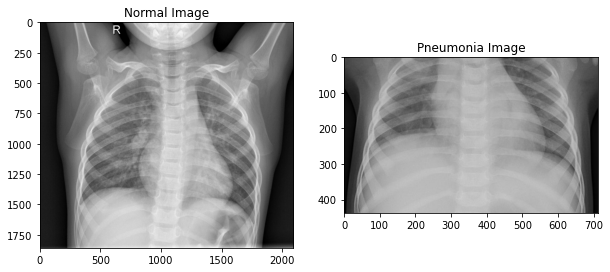

In [3]:
from PIL import Image
#ukázka normálního a nemocného snímku z trénovací množiny
img_normal = Image.open(path + "train\\NORMAL\\IM-0115-0001.jpeg")

img_pneumonia = Image.open(path + "train\\PNEUMONIA\\person1_bacteria_1.jpeg")

img_array_normal = np.array(img_normal)
img_array_pneumonia = np.array(img_pneumonia)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img_array_normal, cmap='gray')
ax[0].set_title("Normal Image")

ax[1].imshow(img_array_pneumonia, cmap='gray')
ax[1].set_title("Pneumonia Image")

plt.show()


Můžeme si hned povšimnout, že oba snimky jsou odlišně škálované, proto je budeme muset přeškálovat na jednu společnou míru pro všechny snímky. Keras nám dovoluje použít třídu ImageDataGenerator, která nám umožní nastavit generátory, které mohou automaticky převést adresáře se snímky na disku do dávek předzpracovaných tenzorů, zároveň nám umožňuje nastavir parametry pro automatickou augmentaci dat pro rozšíření datové množiny.

Terminologie:
- dávka
- epocha
- augmentace

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# jednotna velikost pro skalovani
img_size = 224
# nastaveni poctu epoch a velikosti davek
epochs = 15
batch_size = 20

'''
Instance tridy ImageDataGenerator pro predzpracovani a augmentaci dat.
V trenovaci mnozine preskalujeme hodnoty pixelu snimku na rozsah z intervalu <0,1> a nastavime parametry pro augmentaci.
'''
train_datagen = image_gen = ImageDataGenerator(
                              rescale = 1./255, #preskalovani hodnot pixelu
                              shear_range = 0.2, #hodnota urcujici maximalni uhel (v radianech) pro sikme zkoseni snimku vzhledem k jeho puvodni pozici.
                              rotation_range=40, # roysah ve stupn9ch pro nahodne otaceni snimku
                              zoom_range = 0.2, #hodnota pro nahodne priblizeni uvnitr snimku
                              horizontal_flip = True, #nahodne vodorovne preklopeni poloviny snimku v datove mnozine,
                              width_shift_range=0.1,
                              fill_mode='nearest'
                           )

# instance pro validacni mnozinu - jen preskalujeme hodnoty pixelu
val_datagen = ImageDataGenerator(
                                rescale=1./255
                            )
'''
Nyní vytvorime generator dat pro trenovaci mnozinu, ktera nam bude generovat davky dat ze souboru.
Specifikujeme datovy soubor, velikost davky a velikost snimku
'''
train_gen = train_datagen.flow_from_directory(
                directory= path + 'train', #adresar se snimky
                target_size=(img_size, img_size), # preskalovani velikosti snimku
                batch_size=batch_size, #velikost davky
                class_mode='binary', #parametr urcujici, ze se jedna o binárni klasifikacni problem
                color_mode= 'rgb',
                shuffle=True) #parametr pro nahodne promichani snimku po kazde epose

# generator pro validacni mnozinu
val_gen = val_datagen.flow_from_directory(
                directory= path + 'test',
                target_size=(img_size, img_size),
                batch_size=batch_size,
                class_mode='binary',
                color_mode= 'rgb',
                shuffle=True)

# podiváme se, jak vypadá tenzor generovaný train_gen
for data_batch, labels_batch in train_gen:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Nyní, když máme připravenou datovou mnozinu, můžeme nadefinovat a natrénovat model.

In [5]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, ReLU, Concatenate, AveragePooling2D
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


#definice dense bloku
def dense_block(x, subblocks, filters):
    for i in range(subblocks):
        x1 = Conv2D(filters, kernel_size=3, padding='same')(x)
        x1 = BatchNormalization()(x1)
        x1 = ReLU()(x1)
        x = Concatenate()([x, x1])

    return x

#definice prechodovych bloku
def transition_block(x, filters):
    x = Conv2D(filters, kernel_size=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    return x

# Jednoducha DenseNet Architektura

inputs = Input(shape=(img_size, img_size, 3))

x = Conv2D(16, kernel_size=3, strides=1, padding='same')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

x = dense_block(x, subblocks=1, filters=32)
x = transition_block(x, filters=16)

x = dense_block(x, subblocks=2, filters=64)
x = transition_block(x, filters=32)

x = dense_block(x, subblocks=1, filters=128)
x = transition_block(x, filters=64)
x = Dropout(0.1)(x)

x = dense_block(x, subblocks=1, filters=256)
x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(1, activation='sigmoid')(x)

# Vytvoreni a zkompilovani modelu
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks (= funkce volane v prubehu trenovaciho procesu)

#Tento callback uklada vahy modelu do souboru (urceneho pomoci filepath) po kazde epose, pokud se zlepsi validacní ztrata (save_best_only=True). Nastaveni save_weights_only=True zajistuje, ze jsou ulozeny pouze vahy modelu, nikoliv cely model.
checkpoint = ModelCheckpoint(filepath='best_CNN_weights.hdf5', save_best_only=True, save_weights_only=True)

# vytvoření instance ReduceLROnPlateau, ktery snizuje learning rate, podle sledovane veliciny
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='min')


# fit() aktualizuje parametry modelu na zaklade trenovacich dat a zvoleneho optimalizacniho algoritmu.
hist = model.fit(
            train_gen, #Toto je objekt generatoru, který vytvari davky trenovacich dat.
            steps_per_epoch=train_gen.samples // batch_size,  #Toto je pocet davek, ktere se pouziji pro kazdou epochu trenovani. Jelikoz objekt "train_gen" produkuje davky dat a "train_gen.samples" poskytuje celkovy pocet snimku v trenovaci sade. Delenim tohoto cisla  s "batch_size" ziskame pocet davek v jedne epose.
            epochs=epochs, # Tento parametr udava pocet epoch - pocet opakovani trenovani na cele datove sade
            validation_data=val_gen,
            validation_steps=val_gen.samples // batch_size, # Toto je pocet davek, ktere se pouzijí pro kazdou epochu validace. Podobne jako "steps_per_epoch", vypocita se na zakladě objektu generatoru validačních dat.
            callbacks=[checkpoint, reduce_lr]) # Toto je seznam callbacku, ktere se pouziji behem trenovani. V tomto pripade obsahuje callback kontrolniho bodu a snizovani prumerne rychlosti uceni.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 150, 150, 16  91         ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 150, 16  64         ['separable_conv2d[0][0]']       
 alization)                     )                                                             

Trénování skončilo a mi si můžeme výše prohlédnout základní statistiky. Vidíme, že přesnost klasifikace na trénovacích datech dosáhla v poslední epoše 90 % a na validačních datech  také 90 %, což je poměrně pěkný výsledek. Samozřejmě by se dal ještě zlepšit zvětšením datasetu nebo by se dalo experimentovat s jiným nastavením hyperparametrů..

Nyní si pro lepší přehlednost tyto statistiky vizualizujeme.

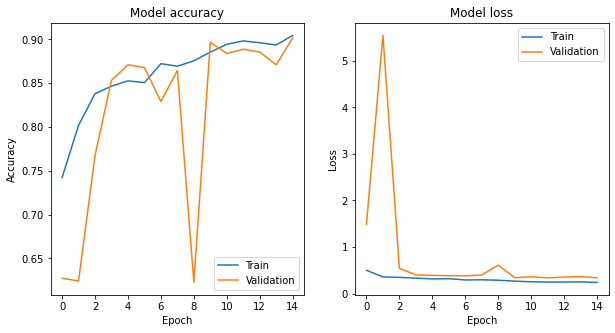

In [6]:
import matplotlib.pyplot as plt

def visualise_stats(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='lower right')

    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper right')

    plt.show()

visualise_stats(hist)

Všimněme si, že v prvních dvou epochách byla validační přesnost a ztráta velice vychýlená v porovnání s trénovací, to kvůli velkému počátečnímu přeučení, které se naštěstí zmenšilo a validační křivky začaly, až na občasné fluktuace, kopírovat ty trénovací.

Nyní se podíváme, jak dobře naše síť predikuje na testovacích (zkombinovaných s validačnimi, kvůli jejich "nedostatku") datech.

In [7]:
x_test = []
y_test = []

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img1 in (os.listdir(path + 'test' + cond)):
        img1 = Image.open(path + 'test' + cond + img1)
        img1 = img1.resize((img_size, img_size))
        img1 = np.dstack([img1, img1, img1])
        img1 = img1.astype('float32') / 255
        if cond=='/NORMAL/':
            label1 = 0
        elif cond=='/PNEUMONIA/':
            label1 = 1
        x_test.append(img1)
        y_test.append(label1)

    for img2 in (os.listdir(path + 'val' + cond)):
        img2 = Image.open(path + 'val' + cond + img2)
        img2 = img2.resize((img_size, img_size))
        img2 = np.dstack([img2, img2, img2])
        img2 = img2.astype('float32') / 255
        if cond=='/NORMAL/':
            label2 = 0
        elif cond=='/PNEUMONIA/':
            label2 = 1
        x_test.append(img2)
        y_test.append(label2)

x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_test.shape)

model.evaluate(x_test, y_test)

(640, 150, 150, 3)
20/20 [==============================] - 2s 101ms/step - loss: 0.3549 - accuracy: 0.8844


[0.3549039959907532, 0.8843749761581421]

Vidíme, že přesnost predikcí dosahuje téměř 89 % a ztráta hodnoty 0.42. To není špatný výsledek, ale mohl by být lepší, zkusíme proto jiný přístup, který se hodí více pro trénování modelu na menším datasetu. Tato metoda využívá tvz. transfer learning, neboli předtrénované neuronové sítě naučené na jiném datasetu. Použijeme předtrénovanou konvoluční architekturu VGG16 natrénovanou na datasetu imagenet. K předtrénované síti připojíme klasifikátor, který budeme trénovat. Je důležité, abychom váhy v předtrénované síti zmrazily, aby se nemohly upravovat a zachovaly si tak již naučené transformace. Až budeme mít klasifikátor natrénovaný, použijeme techniku jemného doladění, kdy poslední blok konvolučních vrstev předtrénované konvoluční sítě odmrazíme a doladíme váhy těchto vrstev pro naší úlohu.

In [8]:
from keras.applications import VGG16

#konvolucni baze
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

#zmrazeni vah
conv_base.trainable = False

#plne propojeny blok
x = Flatten()(conv_base.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

#cely model
model2 = Model(inputs=conv_base.input, outputs=predictions)
model2.compile(optimizer=keras.optimizers.RMSprop(lr=2e-5),
               loss='binary_crossentropy',
               metrics=['accuracy'])
model2.summary()

checkpoint = ModelCheckpoint(filepath='best_weights2.hdf5',
                             save_best_only=True,
                             save_weights_only=True)


#trenovani modelu
hist2 = model2.fit(
            train_gen,
            steps_per_epoch=train_gen.samples // batch_size,
            epochs=epochs,
            validation_data=val_gen,
            validation_steps=val_gen.samples // batch_size,
            callbacks=[checkpoint, reduce_lr])

conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model2.compile(optimizer=keras.optimizers.RMSprop(lr=2e-5),
               loss='binary_crossentropy',
               metrics=['accuracy'])

hist3 = model2.fit(
            train_gen, #Toto je objekt generatoru, který vytvari davky trenovacich dat.
            steps_per_epoch=train_gen.samples // batch_size,
            epochs=epochs,
            validation_data=val_gen,
            validation_steps=val_gen.samples // batch_size,
            callbacks=[checkpoint])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

C:\Users\pajak\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15
260/260 [==============================] - 340s 1s/step - loss: 0.3357 - accuracy: 0.8470 - val_loss: 0.3431 - val_accuracy: 0.8581 - lr: 2.0000e-05
Epoch 2/15
260/260 [==============================] - 347s 1s/step - loss: 0.2116 - accuracy: 0.9222 - val_loss: 0.3416 - val_accuracy: 0.8500 - lr: 2.0000e-05
Epoch 3/15
260/260 [==============================] - 341s 1s/step - loss: 0.1887 - accuracy: 0.9228 - val_loss: 0.2796 - val_accuracy: 0.8887 - lr: 2.0000e-05
Epoch 4/15
260/260 [==============================] - 341s 1s/step - loss: 0.1752 - accuracy: 0.9336 - val_loss: 0.2510 - val_accuracy: 0.9032 - lr: 2.0000e-05
Epoch 5/15
260/260 [==============================] - 344s 1s/step - loss: 0.1621 - accuracy: 0.9411 - val_loss: 0.2919 - val_accuracy: 0.8887 - lr: 2.0000e-05
Epoch 6/15
260/260 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9398
Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.
260/260 [===================

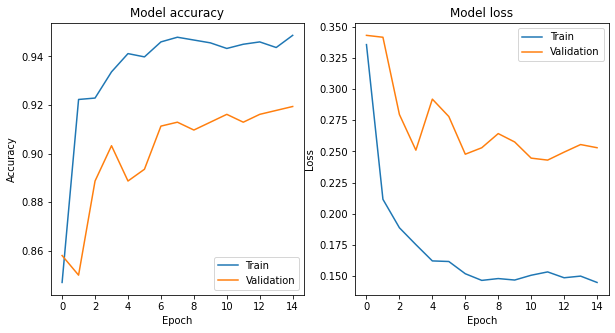

In [9]:
visualise_stats(hist2)

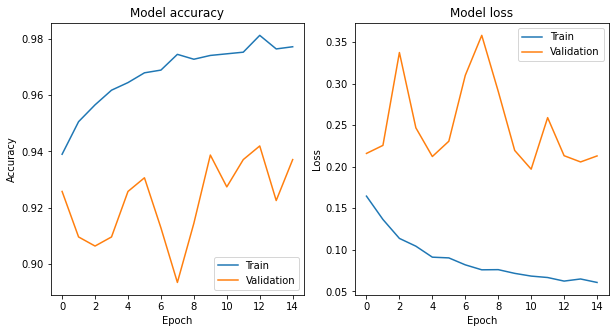

In [10]:
visualise_stats(hist3)